In [22]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

Goals for first analysis
- important features (location type, species name, etc)
- see how many total species there are 
- analysis per city - see if there are any trends we can see
    - eg trees per neighborhood mean and variance
    - same but for tree types 
- ~check how many neighborhoods there are, then neighborhoods per city~ - most cities do not have nbhd information
- plot histogram of tree type counts
- cluster cities based on counts of tree types?
Cities/metropolitan areas:
- 63 in total
- 4454 total tree types
- 148 total cities/separate by metropolitan area instead
- ~4.9m out of 5.6m records have city, same for metro
- check with metropolitan area

In [17]:
cnt = 0
keys = []
d = None
with open("greenspace_data/5_million_trees_us_cities.csv", "r") as file:
    for line in tqdm(file):
        if cnt == 0:
            keys = line.split(',')
            d = {key:set() for key in ["location_name", 
                                       "greater_metro", 
                                       "location_type",
                                       "common_name",
                                       "neighborhood",
                                       "city"]}
        else:
            info = line.split(',')
            if len(info) == len(keys):
                for key in ["location_name", "greater_metro", "location_type", "common_name", "neighborhood", "city"]:
                    d[key].add(info[keys.index(key)])
                    if len(d[key]) == 0:
                        assert False
        cnt += 1

5660269it [00:14, 398148.00it/s]


In [32]:
nb_p_city = {me:{} for me in d["city"]}
cnt = 0
city_cnt = 0
with open("greenspace_data/5_million_trees_us_cities.csv", "r") as file:
    for line in tqdm(file):
        if cnt != 0:
            info = line.split(',')
            if len(info) == len(keys):
                city = info[keys.index('city')]
                nb = info[keys.index('neighborhood')]
                if nb not in nb_p_city[city]:
                    nb_p_city[city][nb]=1
                else:
                    nb_p_city[city][nb] += 1
                if city != '':
                    city_cnt += 1
        cnt += 1

5660269it [00:08, 694158.57it/s]


In [41]:
cnt = 0
tree_cnts_per_metro = {me:{} for me in d['greater_metro']}
with open("greenspace_data/5_million_trees_us_cities.csv", "r") as file:
    for line in tqdm(file):
        if cnt != 0:
            info = line.split(',')
            if len(info) == len(keys):
                metro = info[keys.index('greater_metro')]
                if metro != '':
                    common_name = info[keys.index('common_name')]
                    if common_name not in tree_cnts_per_metro[metro]:
                        tree_cnts_per_metro[metro][common_name]=1
                    else:
                        tree_cnts_per_metro[metro][common_name]+=1
        cnt += 1

5660269it [00:07, 736553.65it/s]


clustering analysis
- start by looking at 100 or so most common trees

In [61]:
cnt = 0
most_common_trees = {me:0 for me in d['common_name']}
with open("greenspace_data/5_million_trees_us_cities.csv", "r") as file:
    for line in tqdm(file):
        if cnt != 0:
            info = line.split(',')
            if len(info) == len(keys):
                common_name = info[keys.index('common_name')]
                #print(common_name)
                if common_name != '':
                    most_common_trees[common_name] +=1
                #print(most_common_trees[common_name])
        cnt += 1

5660269it [00:06, 896446.52it/s]


Text(0, 0.5, '# of species')

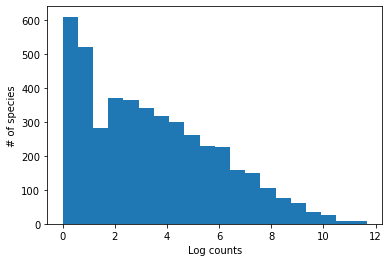

In [69]:

counts = [np.log(most_common_trees[k]) if most_common_trees[k] != 0 else 0 for k in most_common_trees]
plt.hist(counts, bins=20)
plt.xlabel("Log counts")
plt.ylabel("# of species")

In [72]:
counts_w_names = [(most_common_trees[k], k) for k in most_common_trees]
total_count = sum([c[0] for c in counts_w_names])

Text(0, 0.5, 'Percentage of total number of trees comprised by top n')

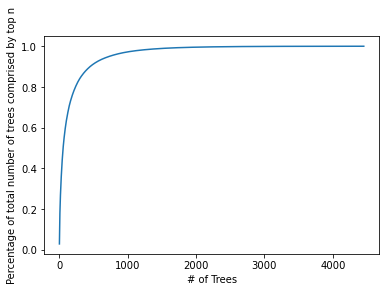

In [82]:
rev_sorted_cnts = sorted([most_common_trees[k] for k in most_common_trees])[::-1]
for i in range(1, len(rev_sorted_cnts)):
    rev_sorted_cnts[i] += rev_sorted_cnts[i-1]
for i in range(len(rev_sorted_cnts)):
    rev_sorted_cnts[i] /= total_count
plt.plot(rev_sorted_cnts)
plt.xlabel("# of Trees")
plt.ylabel("Percentage of total number of trees comprised by top n")

In [94]:
# Take top 1000 names
cnt = 0
sorted_cnts_names = list(map(lambda x: x[1], sorted(counts_w_names)[::-1][:1000]))
met_cnts_names = {me:{n: 0 for n in sorted_cnts_names} for me in d["greater_metro"]}
with open("greenspace_data/5_million_trees_us_cities.csv", "r") as file:
    for line in tqdm(file):
        if cnt != 0:
            info = line.split(',')
            if len(info) == len(keys):
                metro = info[keys.index('greater_metro')]
                if metro != '':
                    common_name = info[keys.index('common_name')]
                    if common_name in sorted_cnts_names:
                        if common_name not in met_cnts_names[metro]:
                            met_cnts_names[metro][common_name]=1
                        else:
                            met_cnts_names[metro][common_name]+=1
        cnt += 1

5660269it [00:18, 304006.59it/s]


In [ ]:
# filter with vacant later 

In [115]:
pca_data = np.zeros((63, 1000))
bad_idxs = []
for i in range(63):
    metro_name = list(d["greater_metro"])[i]
    for j in range(1000):
        pca_data[i][j] = met_cnts_names[metro_name][sorted_cnts_names[j]]
    if (sum(pca_data[i]) == 0):
        bad_idxs.append(i)
idxs = [i for i in range(63) if i not in bad_idxs]
pca_data = pca_data[idxs]
for i in range(len(pca_data)):
    pca_data[i] /= sum(pca_data[i])

In [120]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [123]:
scaler = StandardScaler()
pca_standard = scaler.fit_transform(pca_data)
pca = PCA(n_components=20)
pca.fit(pca_standard)

PCA(n_components=20)

Text(0, 0.5, 'Cumulative fraction of explained variance')

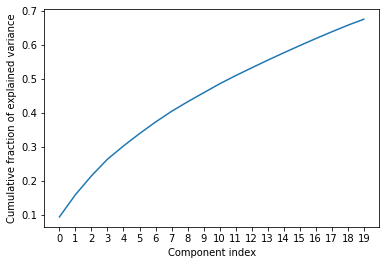

In [126]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xticks(np.arange(20))
plt.xlabel("Component index")
plt.ylabel("Cumulative fraction of explained variance")

In [ ]:
# perform k means on 20 components, then visualize in 2 components space
from sklearn.cluster import KMeans
wcss = []
for i in range(1, 15):
    kmeans = KMeans(n_clusters = i, init = 'k-means++')
    kmeans.fit(pca_standard)